# Project 1 
- 3-layer Neural Network
- 3-layer Convolutional Neural Network

In [2]:
# import modules
import numpy as np
import zipfile
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# prepare dataset
# unzip dataset folder
dataset = zipfile.ZipFile("dataset.zip")
dataset.extractall()

root = "./dataset/"
files = [
    "t10k-images-idx3-ubyte.gz",
    "t10k-labels-idx1-ubyte.gz",
    "train-images-idx3-ubyte.gz",
    "train-labels-idx1-ubyte.gz"
]

# unzip label, image data
with gzip.open(root+files[0],'rb') as f:
    test_image = np.frombuffer(f.read(),np.uint8,offset =16)

with gzip.open(root+files[1],'rb') as f:
    test_label = np.frombuffer(f.read(),np.uint8,offset =8)

with gzip.open(root+files[2],'rb') as f:
    train_image = np.frombuffer(f.read(),np.uint8,offset =16)

with gzip.open(root+files[3],'rb') as f:
    train_label = np.frombuffer(f.read(),np.uint8,offset =8)

train_image = train_image.reshape(-1, 28*28)
test_image = test_image.reshape(-1, 28*28)

print("train data")
print("train image's shape: {}".format(train_image.shape))
print("train label's shape: {}".format(train_label.shape))
print("train image's Min: {}, Max: {}".format(np.min(train_image), np.max(train_image)))

print("test data")
print("test image's shape: {}".format(test_image.shape))
print("test label's shape: {}".format(test_label.shape))

train data
train image's shape: (60000, 784)
train label's shape: (60000,)
train image's Min: 0, Max: 255
test data
test image's shape: (10000, 784)
test label's shape: (10000,)


400th mnist data: 2


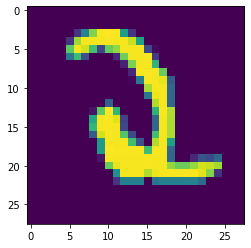

In [4]:
# ckeck data
idx = 400
plt.imshow(train_image[idx].reshape(28, 28))
print("{}th mnist data: {}".format(idx, train_label[idx]))

In [5]:
# normalize
train_image_norm = train_image / 255
test_image_norm  = test_image / 255
print("train image's Min: {}, Max: {}".format(np.min(train_image_norm), np.max(train_image_norm)))

train image's Min: 0.0, Max: 1.0


# Design Sub Modules
### with backpropagation
- Linear Layer
- ReLU
- Conv Layer
- Max Pooling

In [6]:
# Linear Layer and ReLU implementation

class LinearLayer():
    def __init__(self, input_size, output_size, learning_rate):
        np.random.seed(0)
        self.input_size = input_size
        self.output_size = output_size
        self.lr = learning_rate
        self.w = np.random.normal(size = (input_size, output_size)) / 10
        self.b = np.random.normal(size = (1, output_size)) / 10

        # self.dout_w = None
        # self.dout_b = None
        self.input = None

    def forward(self, x):
        if len(x.shape) == 1:
            self.input = np.expand_dims(x, axis=0)
        else:
            self.input = x

        # print("input's shape: {}".format(self.input.shape))   # for debugging
        return  np.matmul(x, self.w) + self.b

    def back_prop(self, dout):
        if self.input.any == None:
            raise Exception("No forward")
        if len(dout.shape) == 1:
            dout = np.expand_dims(dout, axis=0)
        else:
            dout = dout
        dout_w = np.matmul(self.input.T, dout) 
        dout_b = np.sum(dout, axis=0, keepdims=True)
        
        # for debugging        
        # print("dout' shape: {}, input's shape: {}, weight's shape: {}".format(self.dout.shape, self.input.shape, self.w.shape))
        
        # Update 
        self.w -= self.lr * dout_w
        self.b -= self.lr * dout_b

        return np.matmul(dout, self.w.T)

class ReLU():
    def __init__(self):
        self.bool_map = None

    def forward(self, x):
        self.bool_map = (x > 0).astype(np.float32)
        return np.multiply(x, self.bool_map)

    def back_prop(self, dout):
        # print("bool map's shape: {}, dout's shape: {}".format(self.bool_map.shape, dout.shape))
        return np.multiply(dout, self.bool_map)


In [7]:
# im2col, col2im (reference: https://umbum.dev/223)
def im2col(x, f_h, f_w, stride, pad, k_h, k_w, purpose = "Conv"):
    '''
    input: (batch, channel, height, width)
    output
        Conv: (n * f_h * f_w, c * k_h * k_w)
        MaxPooling: (n * f_h * f_w * c, k_h * k_w)
    
    using for forward
    '''
    x = np.pad(x, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    x_n, x_c, x_h, x_w = x.shape
    col = np.random.rand(x_n, x_c, k_h, k_w, f_h, f_w)

    for h in range(k_h):
        h_len = h + stride * f_h
        for w in range(k_w):
            w_len = w + stride * f_w
            col[:, :, h, w, :, :] = x[:, :, h:h_len:stride, w:w_len:stride]
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(x_n*f_h*f_w, x_c*k_h*k_w)
    # (n, c, h, w) => (n * f_h * f_w, c * k_h * k_w)

    if purpose == "Conv":
        return col  # (n * f_h * f_w, c * k_h * k_w)
    elif purpose == "MaxPooling":
        return col.reshape(-1, k_h*k_w) # (n * f_h * f_w * c, k_h * k_w)

def col2im(x, i_shape, o_shape, stride, pad, k_h, k_w):
    '''
    input
        Conv: (n * o_h * o_w, i_c * k_h * k_w)
        MaxPooling: (n * o_h * o_w * c(o_c, i_c), k_h * k_w)

    output: (n, c, i_h, i_w)
    
    using for back prop
    '''
    n, i_c, i_h, i_w = i_shape
    n, o_c, o_h, o_w = o_shape 
    
    x = x.reshape(n, o_h, o_w, i_c, k_h, k_w)
    x = x.transpose(0,3,4,5,1,2)    # (n, i_c, k_h, k_w, o_h, o_w)
    
    im = np.zeros((n, i_c, i_h + 2*pad, i_w + 2*pad))

    for h in range(k_h):
        h_len = h + stride * o_h
        for w in range(k_w):
            w_len = w + stride * o_w
            im[:, :, h:h_len:stride, w:w_len:stride] += x[:, :, h, w, :, :] 
    
    # crop image (due to padding)
    crop_h_len = i_h + pad 
    crop_w_len = i_w + pad
    start = pad
    im = im[:, :, start:crop_h_len, start:crop_w_len]

    return im

In [8]:
# Convolutional Layer and MaxPooling implementation

class ConvLayer():
    def __init__(self, in_channels, out_channels, kernel_size, stride, lr, padding = 0):
        '''
        x = (N(batch), C, H, W)
        kernel = (out_channels, in_channels, H, W)
        '''
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.k_h = kernel_size   # kernel height
        self.k_w = kernel_size   # kernel width
        self.i_shape = None # input shape
        self.o_shape= None # output shape
        self.input_col = None   # input to col

        self.stride = stride
        self.padding = padding

        self.lr = lr
        self.kernel= np.random.normal(size = (self.out_channels, self.in_channels, self.k_h, self.k_w)) / 10
        self.b = np.random.normal(size = (self.out_channels)) / 10
        # self.dout_w = None
        # self.dout_b = None
    
    def forward(self, x):        
        '''
        x: (n, c, h, w) => (n * f_h * f_w, c * k_h * k_w)
        kernel: (o_c, i_c, k_h, k_w) => (o_c, i_c * k_h * k_w) => (i_c * k_h * k_w, o_c)
        np.matmul(x, kernel): (n * f_h * f_w, o_c) => (n, f_h, f_w, o_c) => (n, o_c, f_h, f_w)

        output: (n, o_c, f_h, f_w)
        '''
        self.i_shape = x.shape
        x_n, x_c, x_h, x_w = x.shape    # batch size, channel, height, width

        if self.in_channels != x_c:
            raise Exception("must be same in_channel with input channel")
        f_h = (x_h + 2 * self.padding - self.k_h) / self.stride + 1
        f_w = (x_w + 2 * self.padding - self.k_w) / self.stride + 1
        
        if f_h % 1 != 0 or f_w % 1 != 0:
            print("x_h, x_w: ({}, {})".format(x_h, x_w))
            print("padding: {}".format(self.padding))
            print("k_h, k_w: ({}, {})".format(self.k_h, self.k_w))
            print("stride: {}".format(self.stride))
            raise Exception("wrong parameter!! feature map size is not int")

        # print("f_h, f_w: ({}, {})".format(f_h, f_w))
        f_h, f_w = int(f_h), int(f_w)
        self.o_shape = (x_n, self.out_channels, f_h, f_w)

        x_col = im2col(x, f_h, f_w, self.stride, self.padding, self.k_h, self.k_w)
        self.input_col = x_col
        k_reshape = self.kernel.reshape(self.out_channels, self.in_channels * self.k_h * self.k_w).T

        feature_map = (np.matmul(x_col, k_reshape) + self.b).reshape(x_n, f_h, f_w, self.out_channels)
        feature_map = feature_map.transpose(0, 3, 1, 2) # (n, f_h, f_w, o_c) => (n, o_c, f_h, f_w)

        # for n in range(x_n):
        #     for idx, kernel in enumerate(self.kernel_list):
        #         for i in range(f_h):
        #             h_start = i * self.stride
        #             for j in range(f_w):
        #                 w_start = j * self.stride
        #                 crop_input = pad_x[n, :, h_start:h_start+self.k_h, w_start:w_start+self.k_w]
        #                 # print(n, idx, i, j)
        #                 print("crop input's shape: {}".format(crop_input.shape))
        #                 print("kernel's shape: {}".format(kernel.shape))
        #                 # print(w_start,w_start+self.k_w)
        #                 feature_map[n, idx, i, j] = np.sum(np.multiply(crop_input, kernel))
        return feature_map

    def back_prop(self, dout):
        '''
        dout: (batch, channel, height, width)
        d_kernel: (output channel, input channel, output height, output width)
        '''
        dout = dout.transpose(0, 2, 3, 1)   # (batch, o_c, f_h, f_w) => (batch, f_h, f_w, o_c)
        dout = dout.reshape(-1,self.out_channels)

        dout_w = np.matmul(self.input_col.T, dout)
        dout_b = np.sum(dout, axis=0)

        # update
        self.kernel -= self.lr * dout_w.T.reshape(self.kernel.shape)
        self.b -= self.lr * dout_b

        kernel_col = self.kernel.reshape(self.out_channels, self.in_channels*self.k_h*self.k_w)
        dout_return = np.matmul(dout, kernel_col)
        return col2im(dout_return, self.i_shape, self.o_shape, self.stride, self.padding, self.k_h, self.k_w)   # x, i_shape, o_shape, stride, pad, k_h, k_w



In [14]:
class MaxPooling():
    def __init__(self, kernel_size, stride):
        self.k_h = kernel_size   # kernel height
        self.k_w = kernel_size   # kernel width
        self.stride = stride
        self.i_shape = None # input shape
        self.o_shape= None # output shape
        self.max_position = None
    
    def forward(self, x):
        '''
        x: (n, c, h, w) => (n * p_h * p_w * c, k_h * k_w)
        kernel: (k_h, k_w) 
        np.max(x, axis = 1): (n * p_h * p_w * c, 1) => (n, p_h, p_w, c) => (n, c, p_h, p_w) 

        output: (n, c, p_h, p_w) 
        '''
        self.i_shape = x.shape
        x_n, x_c, x_h, x_w = x.shape

        p_h = (x_h - self.k_h) / self.stride + 1
        p_w = (x_w - self.k_w) / self.stride + 1
        if p_h % 1 != 0 or p_w % 1 != 0:
            print("x_h, x_w: ({}, {})".format(x_h, x_w))
            print("k_h, k_w: ({}, {})".format(self.k_h, self.k_w))
            print("stride: {}".format(self.stride))
            raise Exception("wrong parameter!!! pooling size is not int")

        # print("p_h, p_w: ({}, {})".format(p_h, p_w))
        p_h, p_w = int(p_h), int(p_w)
        self.o_shape = (x_n, x_c, p_h, p_w)

        x_col = im2col(x, p_h, p_w, self.stride, 0, self.k_h, self.k_w, "MaxPooling")
        # print(x_col.shape)
        max_col = np.max(x_col, axis = 1).reshape(x_n, p_h, p_w, x_c)
        self.max_position = np.argmax(x_col, axis = 1)
        return max_col.transpose(0, 3, 1, 2) 

        # for n in range(x_n):
        #     for c in range(x_c):
        #         for i in range(p_h):
        #             h_start = i * self.stride
        #             for j in range(p_w):
        #                 w_start = j * self.stride
        #                 crop_input = x[n, c, h_start:h_start+self.k_h, w_start:w_start+self.k_w]
        #                 max_value = np.max(crop_input)
        #                 # print(n, idx, i, j)
        #                 # if i % 10 == 0 and j % 10 == 0:
        #                 #     print("crop input: {}".format(crop_input))
        #                 #     print("max : {}".format(max_value))
        #                 # print(w_start,w_start+self.k_w)
        #                 pooled_map[n, c, i, j] = max_value

    def back_prop(self, dout):
        '''
        dout: (batch, channel, o_h, o_w)
        return_dout: (batch, channel, i_h, i_w)  
        '''
        dout = dout.transpose(0, 2, 3, 1)
        dout_length = dout.shape[0]*dout.shape[1]*dout.shape[2]*dout.shape[3]
        dmp = np.zeros((dout_length, self.k_h * self.k_w))
        
        dmp[np.arange(dout_length), self.max_position.reshape(1, -1)] += dout.reshape(1, -1)
        # print("dout return shape: {}".format(dout_return.shape))

        return col2im(dmp, self.i_shape, self.o_shape, self.stride, 0, self.k_h, self.k_w)  

# Design Functions
### with dout
- SoftMax
- Cross-Entropy Loss

In [9]:
class SoftMax():
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        sigma = 1e-10
        x -= np.max(x, axis=1, keepdims=True)
        return np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)
        # e_x = np.exp(x - np.max(x, axis=1, keepdims= True)) # prevent overflow
        # if np.any(np.sum(e_x, axis=1, keepdims= True) == np.nan):
        #     print(wrong)
        # return e_x / np.sum(e_x, axis=1, keepdims= True) + sigma

    def back_prop(self, y):
        prop = self.forward(self.x)
        prop[np.arange(prop.shape[0]),y] -= 1
        prop /= self.x.shape[0]
        return prop 

class Cross_Entropy():
    # back prop not used
    def forward(self, y_hat, y):    # y_hat.shape = (batch, 784)
        # if np.isnan(y_hat.any):
        #     print("cross entropy forwarding error")
        return np.sum(-1 * np.log(y_hat[np.arange(y_hat.shape[0]), y]))

# 3-Layer Neural Network(NN)
### sequence
**input - Linear - ReLU - Linear - ReLU - Linear - SoftMax**

In [10]:
class NeuralNetwork():
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, lr):
        self.L1 = LinearLayer(input_size, hidden_size1, lr)
        self.A1 = ReLU()

        self.L2 = LinearLayer(hidden_size1, hidden_size2, lr)
        self.A2 = ReLU()

        self.L3 = LinearLayer(hidden_size2, output_size, lr)
        self.SM = SoftMax()

    def forward(self, x):
        # print("================================================")    
        x = self.A1.forward(self.L1.forward(x))
        # print("L1: ", np.sum(x))
        x = self.A2.forward(self.L2.forward(x))
        # print("L2: ",np.sum(x))
        output = self.SM.forward((self.L3.forward(x)))
        # print("L3: ",np.sum(output))
        return output
        
    def backward(self, label):
        dout = self.SM.back_prop(label)
        # print("SoftMax Backprop's shape: {}".format(dout.shape))
        dout = self.L3.back_prop(dout)
        # print("L3 Backprop's shape: {}".format(dout.shape))

        dout = self.A2.back_prop(dout)
        # print("A2 Backprop's shape: {}".format(dout.shape))
        dout = self.L2.back_prop(dout)
        # print("L2 Backprop's shape: {}".format(dout.shape))

        dout = self.A1.back_prop(dout)
        # print("A1 Backprop's shape: {}".format(dout.shape))
        dout = self.L1.back_prop(dout)
        # print("L1 Backprop's shape: {}".format(dout.shape))



# Neural Network Train PipeLine

In [11]:
# DataLoader implementation
class DataLoader():
    def __init__(self, image, label, batch):
        self.zip_image_label = []
        image_per_batch = []
        label_per_batch = []

        is_divided = False
        if image.shape[0] % batch == 0:
            iteration = image.shape[0] // batch
            is_divided = True
        else:
            iteration = image.shape[0] // batch + 1
            rest = image.shape[0] % batch

        for i in range(iteration):
            if i == iteration - 1 and not is_divided:
                image_per_batch.append(image[i * batch:i * batch + rest])
                label_per_batch.append(label[i * batch:i * batch + rest])
            else:
                image_per_batch.append(image[i * batch:(i+1) * batch])
                label_per_batch.append(label[i * batch:(i+1) * batch])


        for image_label in zip(image_per_batch, label_per_batch):
            self.zip_image_label.append(image_label)

    def __iter__(self):
        return iter(self.zip_image_label)

    def __len__(self):
        return len(self.zip_image_label)


In [325]:
epochs = 50
lr = 1e-3
batch_size = 100
input_size = train_image[0].shape[0]
criterion = Cross_Entropy() 
train_dataset_size = train_image.shape[0]

model_nn = NeuralNetwork(input_size, 100, 50, 10, lr)
train_dataloader = DataLoader(train_image_norm, train_label, batch_size)
nn_train_loss_list = []

test_dataloader = DataLoader(test_image_norm, test_label, batch_size)
nn_test_loss_list = []
test_dataset_size = test_image.shape[0]

print("input size: ", input_size)
print("batch size: ", len(train_dataloader))
print("train image's shape: {}, train label's shape:{}".format(train_image_norm.shape, train_label.shape))
print(np.max(train_image_norm), np.min(train_image_norm))
print("DataLoader length: {}".format(len(train_dataloader)))

for epoch in range(epochs):
    train_cnt = 0
    train_total_loss = 0
    val_cnt = 0
    val_total_loss = 0

    print("================================================")    
    for idx, (image, label) in enumerate(train_dataloader):
        output = model_nn.forward(image)    
        # print("output's shape: {}".format(output.shape))
        loss = criterion.forward(output, label)
        if epoch % 10 == 0 and idx == 0:
            print("gt:    ", label[:20])
            print("output:", np.argmax(output, axis=1)[:20])
        train_cnt += np.array((np.argmax(output, axis=1) == label).astype(np.float16)).sum()
        train_total_loss += loss
        model_nn.backward(label)
    train_total_loss /= train_dataset_size
    nn_train_loss_list.append(train_total_loss)
    train_acc = train_cnt * 100/ train_dataset_size

    print("Train || {} epoch | loss:{} | cnt: {} | acc: {}".format(epoch, train_total_loss, train_cnt, train_acc))   

    for idx, (image, label) in enumerate(test_dataloader):
        output = model_nn.forward(image)    
        # print("output's shape: {}".format(output.shape))
        loss = criterion.forward(output, label)
        if epoch % 10 == 0 and idx == 0:
            print("gt:    ", label[:20])
            print("output:", np.argmax(output, axis=1)[:20])
        val_cnt += np.array((np.argmax(output, axis=1) == label).astype(np.float16)).sum()
        val_total_loss += loss

    val_total_loss /= test_dataset_size
    nn_test_loss_list.append(val_total_loss)
    test_acc = val_cnt * 100/ test_dataset_size
    print("Validataion || {} epoch | loss:{} | cnt: {} | acc: {}".format(epoch, val_total_loss, val_cnt, test_acc))   


        

input size:  784
batch size:  600
train image's shape: (60000, 784), train label's shape:(60000,)
1.0 0.0
DataLoader length: 600
gt:     [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
output: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 9]
Train || 0 epoch | loss:2.2945776978057193 | cnt: 7455.0 | acc: 12.425
gt:     [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
output: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 9 9 9 9]
Validataion || 0 epoch | loss:2.204013937457055 | cnt: 1638.0 | acc: 16.38
Train || 1 epoch | loss:2.1333550288799685 | cnt: 16218.0 | acc: 27.03
Validataion || 1 epoch | loss:2.0559613468323907 | cnt: 3735.0 | acc: 37.35
Train || 2 epoch | loss:1.9709977076407323 | cnt: 26891.0 | acc: 44.818333333333335
Validataion || 2 epoch | loss:1.874177052423987 | cnt: 5006.0 | acc: 50.06
Train || 3 epoch | loss:1.7731327922964848 | cnt: 33545.0 | acc: 55.90833333333333
Validataion || 3 epoch | loss:1.657336785014478 | cnt: 6110.0 | acc: 61.1
Train || 4 epoch | loss:1.5486555000398956 | cnt: 39057.0 | ac

# 3-Layer Convolutional Neural Network(CNN)
### sequence
**input - Conv - ReLU - MaxPooling - Conv - ReLU - MaxPooling - Linear - SoftMax**

In [12]:
class ConvNeuralNetwork():
    def __init__(self, lr):
        # ConvLayer: in_channels, out_channels, kernel_size, stride, lr, padding
        # MaxPooling: kernel_size, stride
        self.C1 = ConvLayer(1, 8, 3, 1, lr, 0)
        self.A1 = ReLU()
        self.MP1 = MaxPooling(2, 2)
        
        self.C2 = ConvLayer(8, 8, 3, 1, lr, 0)
        self.A2 = ReLU()
        self.MP2 = MaxPooling(3, 2)

        # for flatten 
        self.flatten_input_shape = None

        # LinearLayer: input_size, output_size, learning_rate
        self.L3 = LinearLayer(200, 10, lr)
        self.SM = SoftMax()

    def forward(self, x):
        x = self.A1.forward(self.C1.forward(x))
        # print(x.shape)
        x = self.MP1.forward(x)
        # print(x.shape)        
        
        x = self.A2.forward(self.C2.forward(x))
        # print(x.shape)
        x = self.MP2.forward(x)
        # print(x.shape) 

        # flatten 
        self.flatten_input_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        # print(x.shape)

        output = self.SM.forward(self.L3.forward(x))
        # print(x.shape)
        return output

    def backward(self, label):
        dout = self.SM.back_prop(label)
        # print("SoftMax Backprop's shape: {}".format(dout.shape))
        dout = self.L3.back_prop(dout)
        # print("L3 Backprop's shape: {}".format(dout.shape))
        
        # reshape
        dout = dout.reshape(self.flatten_input_shape)
        # print("Unflatten Backprop's shape: {}".format(dout.shape))

        dout = self.MP2.back_prop(dout)
        # print("MP2 Backprop's shape: {}".format(dout.shape))
        dout = self.A2.back_prop(dout)
        # print("A2 Backprop's shape: {}".format(dout.shape))
        dout = self.C2.back_prop(dout)
        # print("C2 Backprop's shape: {}".format(dout.shape))

        dout = self.MP1.back_prop(dout)
        # print("MP1 Backprop's shape: {}".format(dout.shape))
        dout = self.A1.back_prop(dout)
        # print("A1 Backprop's shape: {}".format(dout.shape))
        dout = self.C1.back_prop(dout)
        # print("C1 Backprop's shape: {}".format(dout.shape))

        

# CNN Train PipeLine

In [15]:
epochs = 30
lr = 1e-3
batch_size = 32
input_size = train_image[0].shape[0]
criterion = Cross_Entropy() 

train_dataset_size = train_image.shape[0]
test_dataset_size = test_image.shape[0]

train_image_cnn = train_image_norm.reshape((train_dataset_size, 1, 28, 28))
test_image_cnn = test_image_norm.reshape((test_dataset_size, 1, 28, 28))

model_cnn = ConvNeuralNetwork(lr)
train_dataloader = DataLoader(train_image_cnn, train_label, batch_size)
cnn_train_loss_list = []

test_dataloader = DataLoader(test_image_cnn, test_label, batch_size)
cnn_test_loss_list = []
test_dataset_size = test_image.shape[0]

print("input size: ", input_size)
print("batch size: ", len(train_dataloader))
print("train image's shape: {}, train label's shape:{}".format(train_image_norm.shape, train_label.shape))
print(np.max(train_image_norm), np.min(train_image_norm))
print("DataLoader length: {}".format(len(train_dataloader)))

for epoch in range(epochs):
    train_cnt = 0
    train_total_loss = 0
    val_cnt = 0
    val_total_loss = 0

    print("================================================")    
    for idx, (image, label) in enumerate(train_dataloader):
        output = model_cnn.forward(image)    
        # print("output's shape: {}".format(output.shape))
        loss = criterion.forward(output, label)
        if epoch % 10 == 0 and idx == 0:
            print("gt:    ", label[:20])
            print("output:", np.argmax(output, axis=1)[:20])
            
        train_cnt += np.array((np.argmax(output, axis=1) == label).astype(np.float16)).sum()
        train_total_loss += loss
        model_cnn.backward(label)
    train_total_loss /= train_dataset_size
    cnn_train_loss_list.append(train_total_loss)
    train_acc = train_cnt * 100/ train_dataset_size

    
    print("Train || {} epoch | loss:{} | cnt: {} | acc: {}".format(epoch, train_total_loss, train_cnt, train_acc))   

    for idx, (image, label) in enumerate(test_dataloader):
        output = model_cnn.forward(image)    
        # print("output's shape: {}".format(output.shape))
        loss = criterion.forward(output, label)
        if epoch % 10 == 0 and idx == 0:
            print("gt:    ", label[:20])
            print("output:", np.argmax(output, axis=1)[:20])
        val_cnt += np.array((np.argmax(output, axis=1) == label).astype(np.float16)).sum()
        val_total_loss += loss

    val_total_loss /= test_dataset_size
    cnn_test_loss_list.append(val_total_loss)
    test_acc = val_cnt * 100/ test_dataset_size

    print("Validataion || {} epoch | loss:{} | cnt: {} | acc: {}".format(epoch, val_total_loss, val_cnt, test_acc))   

input size:  784
batch size:  1875
train image's shape: (60000, 784), train label's shape:(60000,)
1.0 0.0
DataLoader length: 1875
gt:     [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
output: [9 9 9 5 9 5 9 9 9 9 9 5 9 9 9 5 9 5 9 9]


KeyboardInterrupt: 

# Draw Figures

### Loss Graph

In [ ]:
def plot_loss_graph(train_loss_list, test_loss_list, model):
    """
    param:
        train_loss_list: [epoch1's train loss, epoch2's train loss, ...]

        test_loss_list: [epoch1's test loss, epoch2's test loss, ...]

        model: model name
    """
    epoch = len(train_loss_list)
    sns.lineplot(range(epoch), train_loss_list, label = "train loss", color = "blue")
    sns.lineplot(range(epoch), test_loss_list, label = "test loss", color = "red")

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("{}'s Train & Test loss graph".format(model))
    plt.show()

C:\Users\pc\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\pc\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


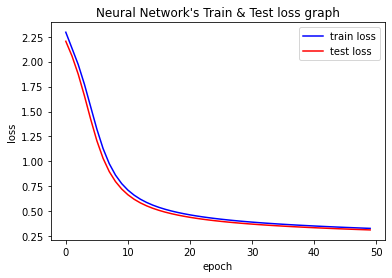

In [ ]:
# Neural Network loss
plot_loss_graph(nn_train_loss_list, nn_test_loss_list, "Neural Network")

C:\Users\pc\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\pc\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


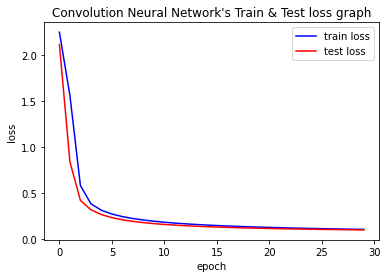

In [ ]:
# Convolution Neural Network loss
plot_loss_graph(cnn_train_loss_list, cnn_test_loss_list, "Convolution Neural Network")

### Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_pred, y_label, model):
    """
    param:
        y_pred: (test_dataset's size, 1)
                model prediction and argmax 
        y_label: (test_dataset's size, 1)
                label list
        model: model name
    """


    confusion_matrix = np.zeros((10, 10))

    for y_pred, label in zip(y_pred, y_label):
        confusion_matrix[label, y_pred] += 1
    
    for i in range(len(np.unique(y_label))):
        sum_row = np.sum(confusion_matrix[i, :])
        confusion_matrix[i] /= sum_row
    
    plt.figure(figsize= (10, 10))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("{}'s Confusion Matrix".format(model))
    plt.colorbar()
    plt.xticks( range(10))
    plt.yticks( range(10))
    plt.tight_layout()
    plt.ylabel('Y Label')
    plt.xlabel('Y Prediction')
    for i in range(10):
        for j in range(10):
            plt.text(i, j, "{:.2f}".format(confusion_matrix[i, j]), va="center", ha="center")
    
    plt.show()


In [ ]:
output_nn = model_nn.forward(test_image_norm)
y_pred_nn = np.argmax(output_nn, axis=1)

In [ ]:
output_cnn = model_cnn.forward(test_image_cnn)
y_pred_cnn = np.argmax(output_cnn, axis=1)

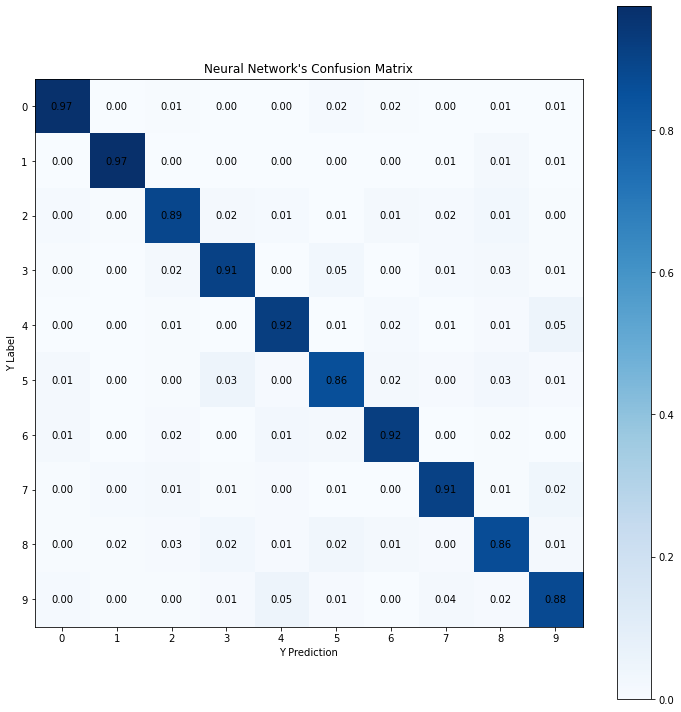

In [ ]:
plot_confusion_matrix(y_pred_nn, test_label, "Neural Network")

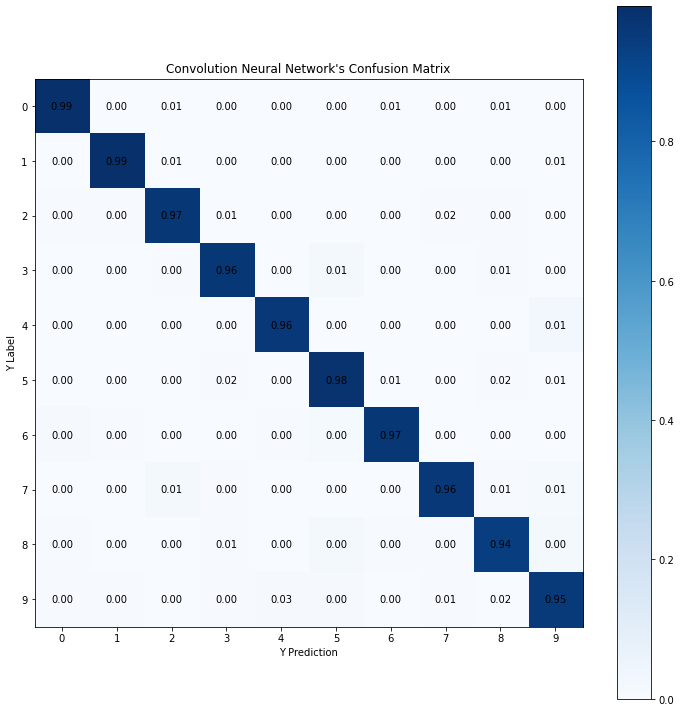

In [ ]:
plot_confusion_matrix(y_pred_cnn, test_label, "Convolution Neural Network")

### Top-3 Images with probability

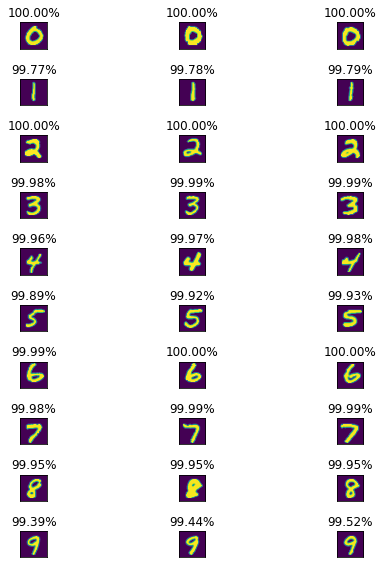

In [ ]:
# top 3 images with probability - Neural Network

sorted_output_nn = np.sort(output_nn, axis=0)
top_3_prob_nn = sorted_output_nn[-3:]
fig = plt.figure(figsize=(8, 8))

for i in range(10):
    output_number = output_nn[:, i]
    top_3_prob_number = top_3_prob_nn[:, i]
    for j in range(3):
        idx = np.where(output_number == top_3_prob_number[j])
        image = test_image[idx].reshape(28, 28)
        ax = fig.add_subplot(10, 3, i*3+j + 1)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.title.set_text("{:.2f}%".format(top_3_prob_number[j] * 100))
        ax.imshow(image)
plt.tight_layout()

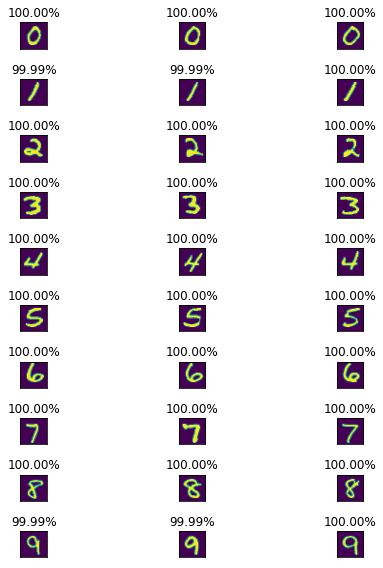

In [ ]:
# top 3 images with probability - Neural Network

sorted_output_cnn = np.sort(output_cnn, axis=0)
top_3_prob_cnn = sorted_output_cnn[-3:]
fig = plt.figure(figsize=(8, 8))

for i in range(10):
    output_number = output_cnn[:, i]
    top_3_prob_number = top_3_prob_cnn[:, i]
    for j in range(3):
        idx = np.where(output_number == top_3_prob_number[j])

        image = test_image[idx].reshape(28, 28)
        ax = fig.add_subplot(10, 3, i*3+j + 1)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.title.set_text("{:.2f}%".format(top_3_prob_number[j] * 100))
        ax.imshow(image)
plt.tight_layout()